# Import Packages

In [10]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm as tqdm
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import os
import seaborn as sns
from scipy import signal
from scipy import optimize
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Define Functions

In [11]:
def analyze_fret(embryo_dir, framerate=30, b_corr=True):
    
    # Load images
    fnames = os.listdir(embryo_dir)
    fnames_2 = list()
    for fname in fnames:
        if b_corr:
            if 'DUP' in fname: # Ensures that we're looking at bleach-corrected embryos
                fnames_2.append(fname)
        elif not b_corr:
            if 'DUP' not in fname and '.tif' in fname:
                fnames_2.append(fname)
    fret_channel = io.imread(embryo_dir + fnames_2[0])
    cfp_channel = io.imread(embryo_dir + fnames_2[1])
    
    # Initialize pandas dataframe
    cfp_statistics = {'mean': [], 'st_dev': []} # Initialize cfp data
    fret_statistics = {'mean': [], 'st_dev': []} # Initialize fret data
    
    # Make measurements on intensities
    for i in tqdm(range(0, len(cfp_channel))): # Iterate through each timeframe
        cfp_ints = cfp_channel[i].flatten()
        cfp_statistics['mean'].append(np.mean(cfp_ints))
        cfp_statistics['st_dev'].append(np.std(cfp_ints))

        fret_ints = fret_channel[i].flatten()
        fret_statistics['mean'].append(np.mean(fret_ints))
        fret_statistics['st_dev'].append(np.std(fret_ints))
    
    # Change into dataframes
    cfp_pd = pd.DataFrame(cfp_statistics)
    fret_pd = pd.DataFrame(fret_statistics)
    
    # Calculate FRET
    fret_eff = []
    for i in range(0, len(cfp_pd)):
        fret_eff.append(fret_pd['mean'][i]/cfp_pd['mean'][i])
        
    # Add a time axis
    cfp_pd = cfp_pd.reset_index()
    cfp_pd['time (s)'] = cfp_pd['index'] * framerate
    cfp_pd['time (min)'] = cfp_pd['time (s)']/60
    
    # Make FRET Ratio Dataframe
    fret_eff_pd = {'fret_em': fret_pd['mean'], 'cfp_em': cfp_pd['mean'],
                   'fret_ratio':fret_eff, 'time (s)': cfp_pd['time (s)'], 
                   'time (min)': cfp_pd['time (min)']}
    fret_eff_pd = pd.DataFrame(fret_eff_pd)
    
    return fret_eff_pd

In [12]:
def plot_function(df_scr, df_cyc, scr_start, scr_stop, cyc_start, cyc_stop, out_dir, 
                  trim=False, norm_init=False, save=False):
    
    if not trim:
        scr_start = 0
        scr_stop = len(df_scr)
        cyc_start = 0
        cyc_stop = len(df_cyc)
    if not norm_init:
        norm_factor_scr = 1
        norm_factor_cyc = 1
        y_axis_label = 'Emission Ratio (AU)'
    elif norm_init:
        norm_factor_scr = df_scr['fret_ratio'][0]
        norm_factor_cyc = df_cyc['fret_ratio'][0]
        y_axis_label = '% Initial Emission Ratio'
        
    plt.plot(df_scr['time (min)'][scr_start:scr_stop] - df_scr['time (min)'][scr_start:scr_stop].min(), 
             df_scr['fret_ratio'][scr_start:scr_stop]/norm_factor_scr, 
             color='black', label='Scrambled dsRNA')
    plt.plot(df_cyc['time (min)'][cyc_start:cyc_stop] - df_cyc['time (min)'][cyc_start:cyc_stop].min(), 
             df_cyc['fret_ratio'][cyc_start:cyc_stop]/norm_factor_cyc, 
             color='red', label='Cyclin A/B/B3 dsRNA')
    plt.legend()
    plt.xlabel('Time (min.)')
    plt.ylabel(y_axis_label)
    
    if save:
        plt.savefig(out_dir)

In [15]:
# Define double exponential decay
def dual_exp_decay(x, tau_1, tau_2, init_1, init_2, base):
    return base+init_1*np.exp(-tau_1 * x)+init_2*np.exp(-tau_2 * x)

In [16]:
def exp_decay(x, a, b, c):
    return a*np.exp(-b * x)+c

In [17]:
def plot_fit_comparison(df, data, channel, fname, out_dir='../Outputs/fits/cyclin_dsRNA/', save=False):
    init = data[0] - data[len(data)-1]
    half_val = data[0] - init/2
    
    popt, pcov = optimize.curve_fit(dual_exp_decay, df['time (s)'], data,
                               p0=[1/30, 1/30, init/2, init/2, data[len(data)-1]], maxfev=10000)
    # Some data is harder to fit with parameters, and so I increased 'maxfev' parameter to 10000
    
    y = dual_exp_decay(df['time (s)'], popt[0], popt[1], popt[2], popt[3],
             popt[4])
    popt_1, pcov_1 = optimize.curve_fit(exp_decay, df['time (s)'], data,
                                    p0=[50, 0.05, 280])
    y_single = exp_decay(df['time (s)'], popt_1[0], popt_1[1], popt_1[2])
    
    plt.plot(y, linestyle='-', label='Double Exponential')
    plt.plot(y_single, linestyle='--', label='Single Exponential')
    plt.plot(data, label='Raw')
    plt.legend()
    plt.title(channel + ' Emission Fit Comparison')
    if save:
        plt.savefig(out_dir + fname)

In [1]:
def function_correction(dat, t, a, b, c, d, e):
    
    # Account for the background (the non-decaying component)
    popt, pcov = optimize.curve_fit(dual_exp_decay, t, dat,
                                    p0=[a, b, c, d, e], maxfev=10000)
    a_1, b_1, c_1, d_1, e_1 = popt
    print('Half-life 1 is:', a_1)
    print('Half-life 2 is:', b_1)
    print('There is no Half-Life 3. Steam, please release it soon! :)')
    func = (c_1 + d_1 + e_1)/dual_exp_decay(t, a_1, b_1, c_1, d_1, e_1)
    corr = (dat) * func
    
    return corr

# Rationale for modeling our data with a bi-exponential decay
In previous analyses, we used FIJI's bleach correction algorithm with exponential decay. Upon inspection of our data's fit to a single exponential decay, however, we noticed that the dynamics were not described accurately. As such, we looked at modeling our data as a sum of two exponentials. We observed that the decay due to photobleaching of both the acceptor (YPet) and the donor (mCerulean) was, indeed, better described by a double-exponential decay than that of a single exponential decay (see figure below).
<img src="Single vs Double Exponential Fits.png">

# Double exponential decay modeling

In [34]:
control_rnai_path = '../Data/20221215_Cdk1-FRET;Sqh-mCh_scr-dsRNA/embryo_2/' # Load in the control RNAi embryo data
cyclin_rnai_path = '../Data/20221218_Cdk1-FRETSqh-mCh_cyclin-dsRNA/series/' # Load in the cyclin RNAi embryo data

## Control RNAi

In [35]:
control_rnai = analyze_fret(control_rnai_path, b_corr=False) # Measure mean fluorescence intensities for the acceptor/donor channels

100%|██████████████████████████████████████████| 94/94 [00:00<00:00, 103.00it/s]


In [36]:
# Using the FRET acceptor's dynamics, fit to a double exponential decay
control_fret = function_correction(control_rnai['fret_em'], control_rnai['time (s)'],
                           0.05, 0.05, 30, 30, 330)

Half-life 1 is: 0.010203064271179115
Half-life 2 is: 0.0007078451310036379
There is no Half-Life 3


/home/aydoganlab/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [37]:
# Using the donor's dynamics, fit to a double exponential decay
control_cfp = function_correction(control_rnai['cfp_em'], control_rnai['time (s)'],
                           0.05, 0.05, 30, 30, 330)

Half-life 1 is: 0.0006668321836405999
Half-life 2 is: 0.0006668418338623475
There is no Half-Life 3


In [38]:
# Take the ratio of the corrected channels' signal
# Same method was done for the Cyclin A/B/B3 RNAi section
control_fret_ratio = control_fret/control_cfp
control_fret_norm = control_fret_ratio/np.max(control_fret_ratio)

## Cyclin A/B/B3 RNAi data

In [40]:
cyclin_rnai = analyze_fret(cyclin_rnai_path, b_corr=False)

100%|█████████████████████████████████████████| 117/117 [00:03<00:00, 36.80it/s]


In [41]:
cyclin_fret = function_correction(cyclin_rnai['fret_em'], cyclin_rnai['time (s)'],
                           0.05, 0.05, 30, 20, 260)

Half-life 1 is: 0.004482749342464853
Half-life 2 is: 0.00042866956781073085
There is no Half-Life 3


/home/aydoganlab/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [42]:
cyclin_cfp = function_correction(cyclin_rnai['cfp_em'], cyclin_rnai['time (s)'],
                                   0.05, 0.05, 30, 20, 260)

Half-life 1 is: 0.0012372005217629984
Half-life 2 is: 1.90904506072435e-07
There is no Half-Life 3


In [43]:
cyclin_fret_ratio = cyclin_fret/cyclin_cfp
cyclin_fret_norm = cyclin_fret_ratio/np.max(cyclin_fret_ratio)

# Compare Dynamics

Text(0.5, 1.0, 'Normalized to Beginning')

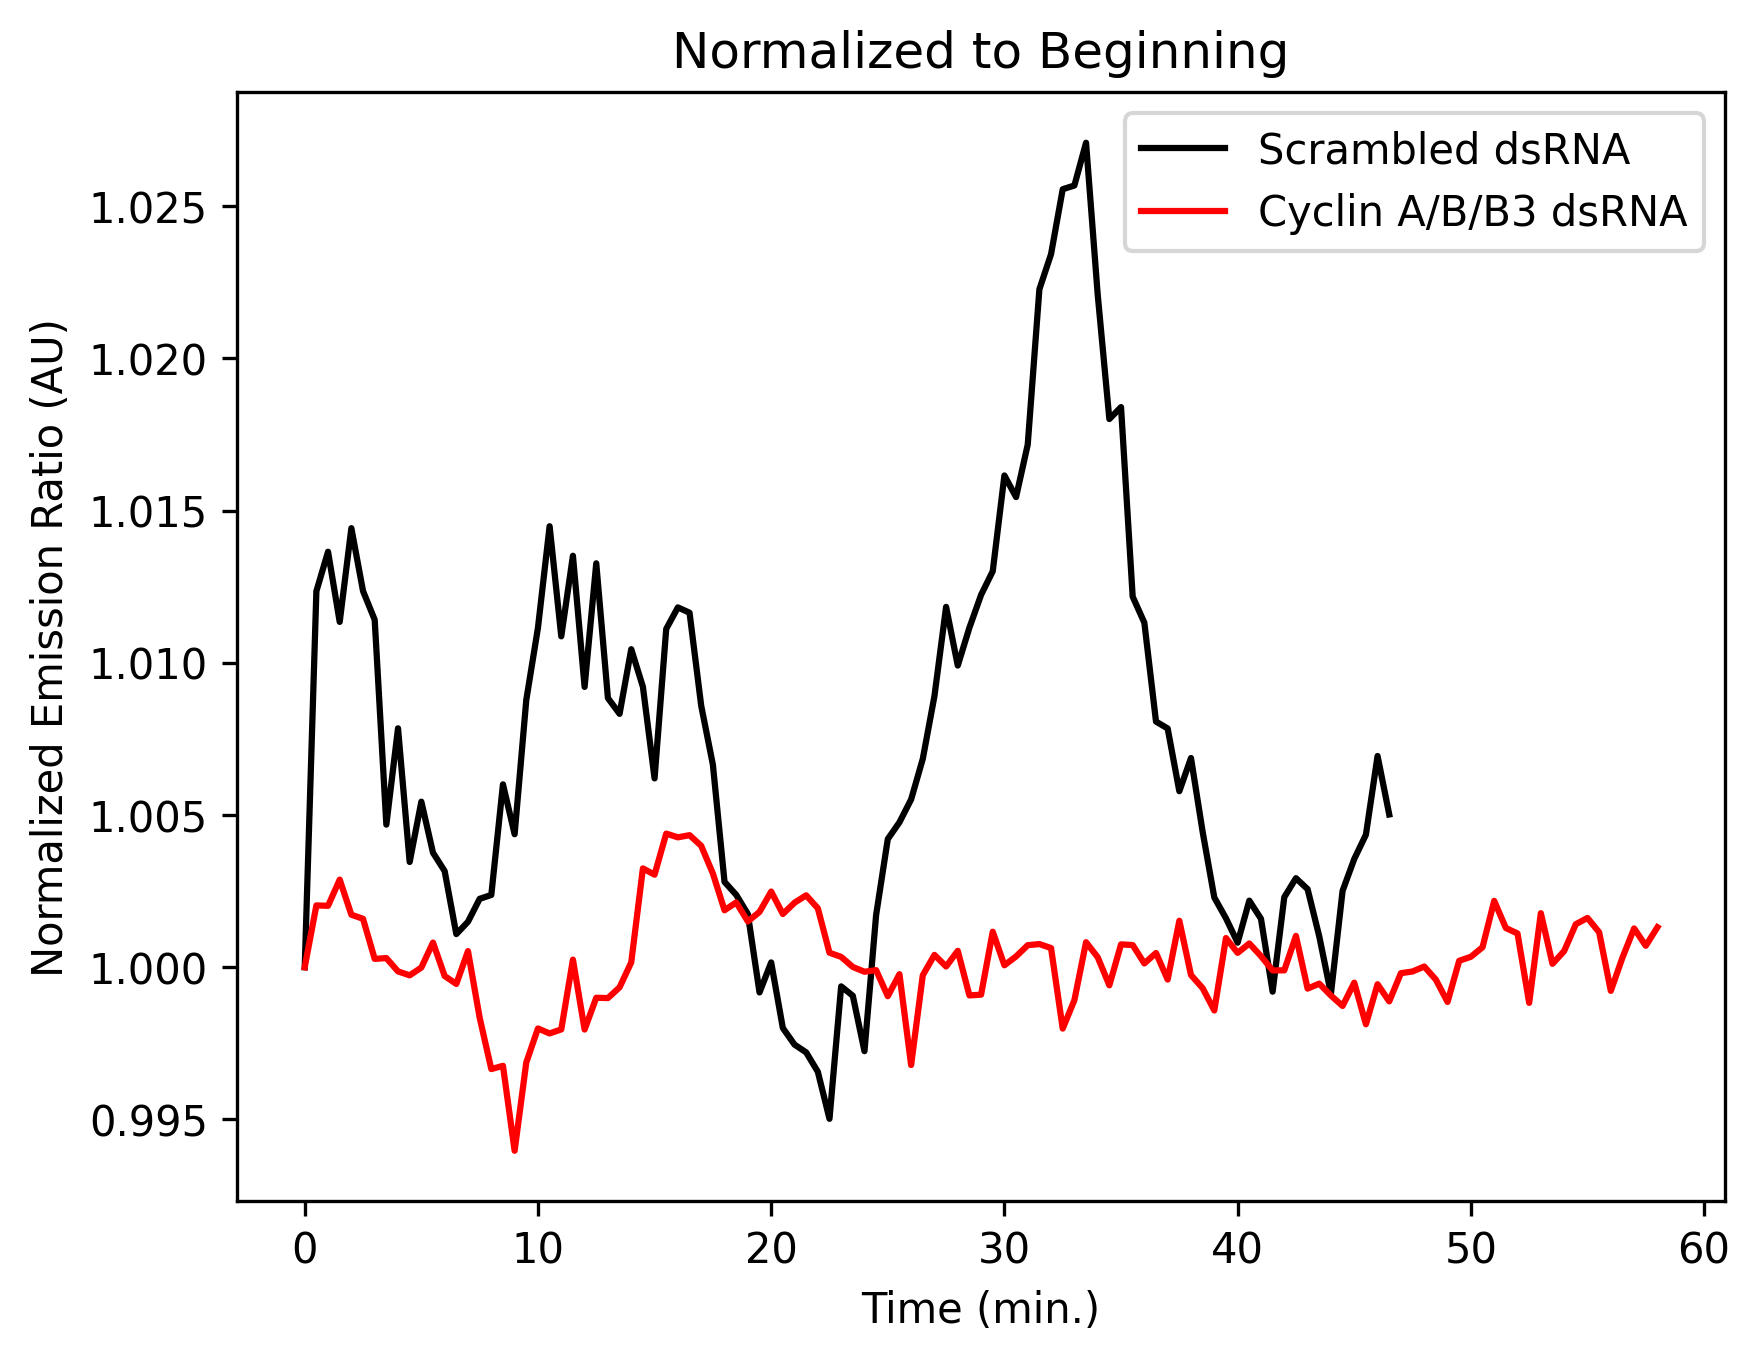

In [31]:
plt.plot(control_rnai['time (min)'], control_fret_ratio/control_fret_ratio[0], 
         label='Scrambled dsRNA', color='black')
plt.plot(cyclin_rnai['time (min)'], cyclin_fret_ratio/cyclin_fret_ratio[0], 
         label='Cyclin A/B/B3 dsRNA', color='red')
plt.legend()
plt.ylabel('Normalized Emission Ratio (AU)')
plt.xlabel('Time (min.)')
plt.title('Normalized to Beginning')
#plt.savefig('../Outputs/double_exponential_correction_draft_full-timeframe.pdf')

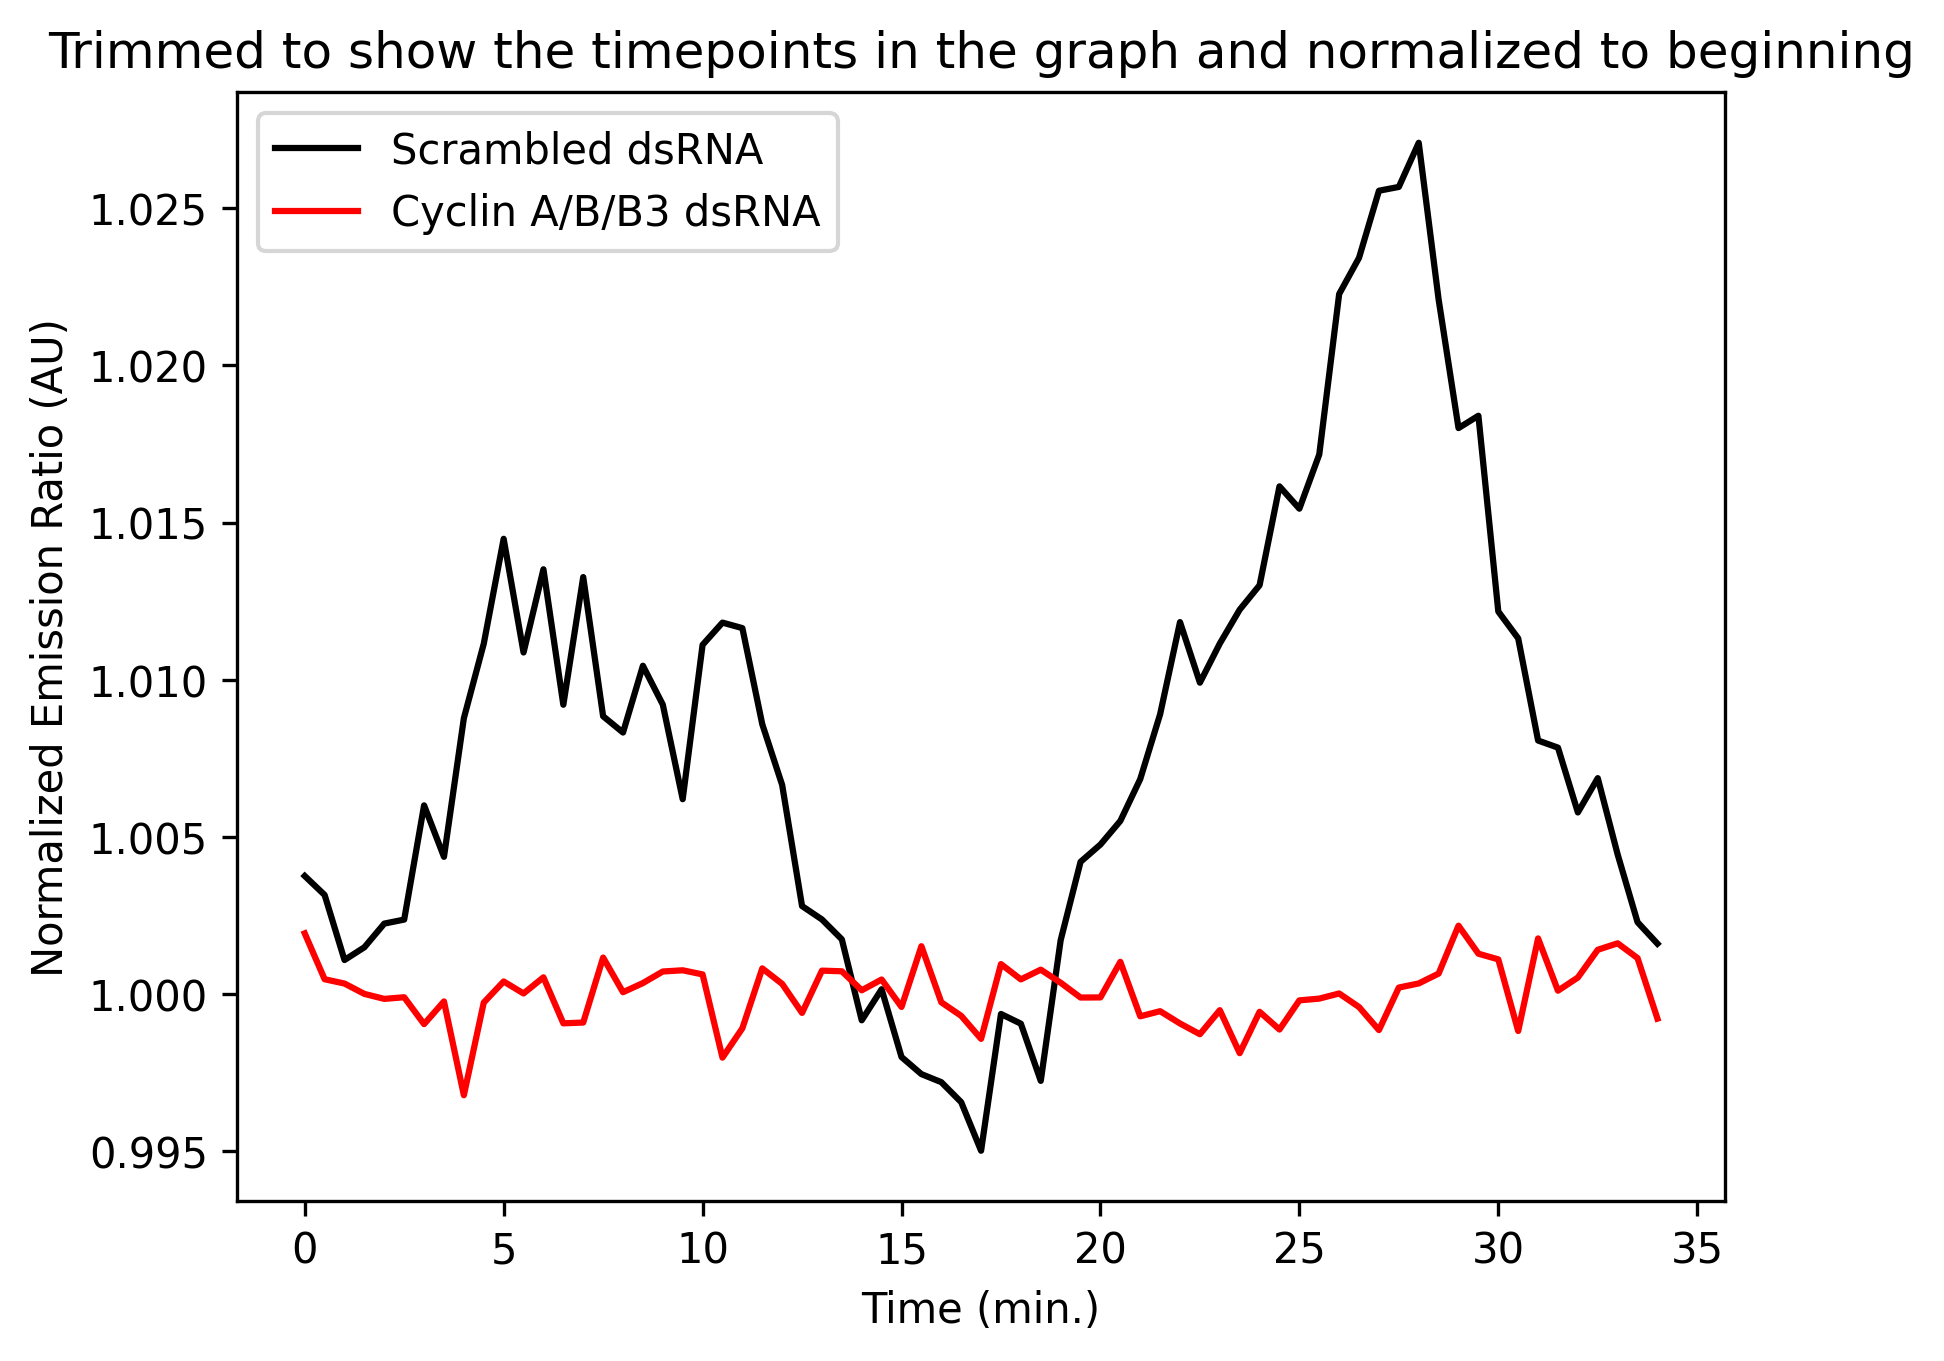

In [32]:
plt.plot(control_rnai['time (min)'][11:80] - control_rnai['time (min)'][11:80].min(), 
             control_fret_ratio[11:80]/control_fret_ratio[0], 
             color='black', label='Scrambled dsRNA')
plt.plot(cyclin_rnai['time (min)'][44:113] - cyclin_rnai['time (min)'][44:113].min(), 
         cyclin_fret_ratio[44:113]/cyclin_fret_ratio[0], 
         color='red', label='Cyclin A/B/B3 dsRNA')
plt.ylabel('Normalized Emission Ratio (AU)')
plt.xlabel('Time (min.)')
plt.title('Trimmed to show the timepoints in the graph and normalized to beginning')
plt.legend()
#plt.savefig('../Outputs/double_exponential_correction_draft.pdf')